In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
import pytz
import nltk
import webbrowser
import os
import plotly.express as px
import plotly.io as pio

In [32]:
apps_df = pd.read_csv('/Users/muskansharma/Desktop/google_play_store_dataset.csv')
reviews_df = pd.read_csv('/Users/muskansharma/Desktop/reviews.csv')

In [33]:
apps_df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"5,00,000",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"50,00,000",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"5,00,00,000",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"1,00,000",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [34]:
reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [35]:
def is_time_between(start_hour, end_hour):
    ist = pytz.timezone('Asia/Kolkata')
    current_time = datetime.now(ist)
    return start_hour <= current_time.hour < end_hour

In [36]:
html_files_path="./"
if not os.path.exists(html_files_path):
    os.makedirs(html_files_path)
plot_containers=""

In [37]:
# Save each Plotly figure to an HTML file
def save_plot_as_html(fig, filename, insight):
    global plot_containers
    filepath = os.path.join(html_files_path, filename)
    html_content = pio.to_html(fig, full_html=False, include_plotlyjs='inline')
    # Append the plot and its insight to plot_containers
    plot_containers += f"""
    <div class="plot-container" id="{filename}" onclick="openPlot('{filename}')">
        <div class="plot">{html_content}</div>
        <div class="insights">{insight}</div>
    </div>
    """
    fig.write_html(filepath, full_html=False, include_plotlyjs='inline')


In [38]:
plot_width=400
plot_height=300
plot_bg_color='black'
text_color='white'
title_font={'size':16}
axis_font={'size':12}

In [39]:
def preprocess_apps(apps_df):
    apps_df['Last Updated'] = pd.to_datetime(apps_df['Last Updated'], errors='coerce')
    apps_df['Installs'] = apps_df['Installs'].str.replace('[+,]', '', regex=True).replace('Free', np.nan).astype(float)
    apps_df['Size'] = apps_df['Size'].replace('Varies with device', np.nan)
    apps_df['Size_MB'] = apps_df['Size'].str.replace('M', '').astype(float)
    return apps_df

In [40]:
def preprocess_apps(apps_df):
    apps_df['Installs'] = apps_df['Installs'].str.replace('[+,]', '', regex=True).replace('Free', np.nan).astype(float)
    apps_df['Size'] = apps_df['Size'].replace('Varies with device', np.nan)
    
    # Handle 'M' and 'k' separately
    apps_df['Size_MB'] = apps_df['Size'].str.replace('M', '', regex=False)
    apps_df['Size_MB'] = apps_df['Size_MB'].str.replace('k', '', regex=False)

    # Now convert to float
    apps_df['Size_MB'] = apps_df['Size_MB'].astype(float)

    # If it was originally 'k', divide by 1024 to convert KB -> MB
    apps_df.loc[apps_df['Size'].str.contains('k', na=False), 'Size_MB'] /= 1024

    return apps_df


In [41]:
## TASK - 01 Generate WordCloud for 5-star Reviews

In [42]:

from textblob import TextBlob

# Define the function to calculate subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Apply the function to the 'Reviews' column
apps_df["Sentiment_Subjectivity"] = apps_df["Reviews"].apply(get_subjectivity)


In [43]:
plot_containers_split=plot_containers.split('</div>')
if len(plot_containers_split) > 1:
    final_plot=plot_containers_split[-2]+'</div>'
else:
    final_plot=plot_containers

In [44]:
def generate_wordcloud(reviews_df, apps_df):
    # Merge apps and reviews
    merged = reviews_df.merge(apps_df, on='App', how='left')

    # Filter Health & Fitness apps with 5 star reviews
    health_reviews = merged[
        (merged['Category'] == 'HEALTH_AND_FITNESS') &
        (merged['content'].notnull()) &
        (merged['Sentiment'] == 'Positive')
    ]

In [45]:
# If you're working with apps_df instead of df
apps_df["Sentiment_Subjectivity"] = apps_df["Reviews"].apply(get_subjectivity)
# Load or define the DataFrame 'df' before using it
df = apps_df  # or any other DataFrame you want to work with
df["Sentiment_Subjectivity"] = df["Reviews"].apply(get_subjectivity)


In [46]:
# Function to calculate subjectivity
def get_subjectivity(text):
    try:
        return TextBlob(str(text)).sentiment.subjectivity
    except:
        return None

# Apply it to the 'Reviews' column
df["Sentiment_Subjectivity"] = df["Reviews"].apply(get_subjectivity)

In [47]:

def generate_wordcloud(reviews_df, apps_df):
    # Merge apps and reviews
    merged = reviews_df.merge(apps_df, on='App', how='left')

    # Filter Health & Fitness apps with 5 star reviews
    health_reviews = merged[
        (merged['Category'] == 'HEALTH_AND_FITNESS') &
        (merged['content'].notnull()) &
        (merged['Sentiment'] == 'Positive')
    ]
    
    # Now you can use health_reviews inside this function
    stopwords = set(STOPWORDS)
    app_names = set(health_reviews['appId'].str.lower())
    stopwords.update(app_names)
    
    # Generate word cloud or any other operations here


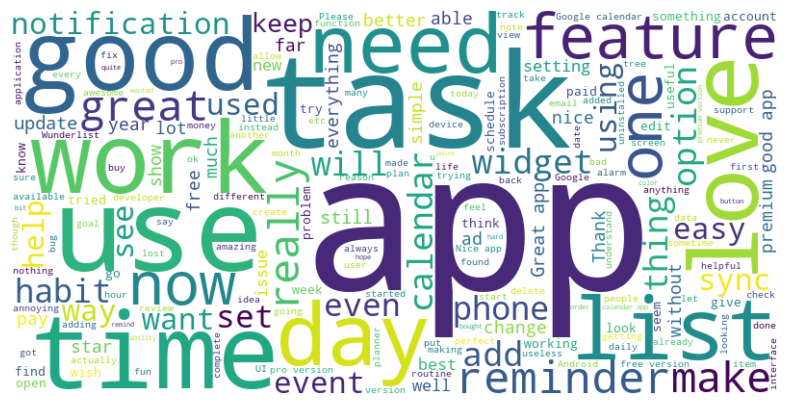

In [48]:
text = " ".join(review for review in reviews_df['content'].dropna())

# Define stopwords
stopwords = set(STOPWORDS)

# Generate the wordcloud
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)

# Display the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [49]:
## TASK - 02 Grouped Bar Chart(3pm to 5pm IST)

In [50]:
def plot_grouped_bar_chart(apps_df):
    if not is_time_between(15, 17):
        print("⏰ It's not time for the Grouped Bar Chart (allowed: 3PM-5PM IST)")
        return

In [51]:
# Step 1: Preprocess 'Size' to create 'Size_MB'
apps_df['Size'] = apps_df['Size'].replace('Varies with device', np.nan)
apps_df['Size_MB'] = apps_df['Size'].str.replace('M', '', regex=False)
apps_df['Size_MB'] = apps_df['Size_MB'].str.replace('k', '', regex=False)
apps_df['Size_MB'] = pd.to_numeric(apps_df['Size_MB'], errors='coerce')
apps_df.loc[apps_df['Size'].str.contains('k', na=False), 'Size_MB'] /= 1024

# Step 2: Convert 'Last Updated' to datetime
apps_df['Last Updated'] = pd.to_datetime(apps_df['Last Updated'], errors='coerce')

# Step 3: Now safely filter
filtered_apps = apps_df[
    (apps_df['Rating'] >= 4.0) &
    (apps_df['Size_MB'] >= 10) &
    (apps_df['Last Updated'].dt.month == 1)
]

/var/folders/9l/zb4vlmj14_z8vp60sws1cj340000gn/T/ipykernel_91316/1515805204.py:16: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



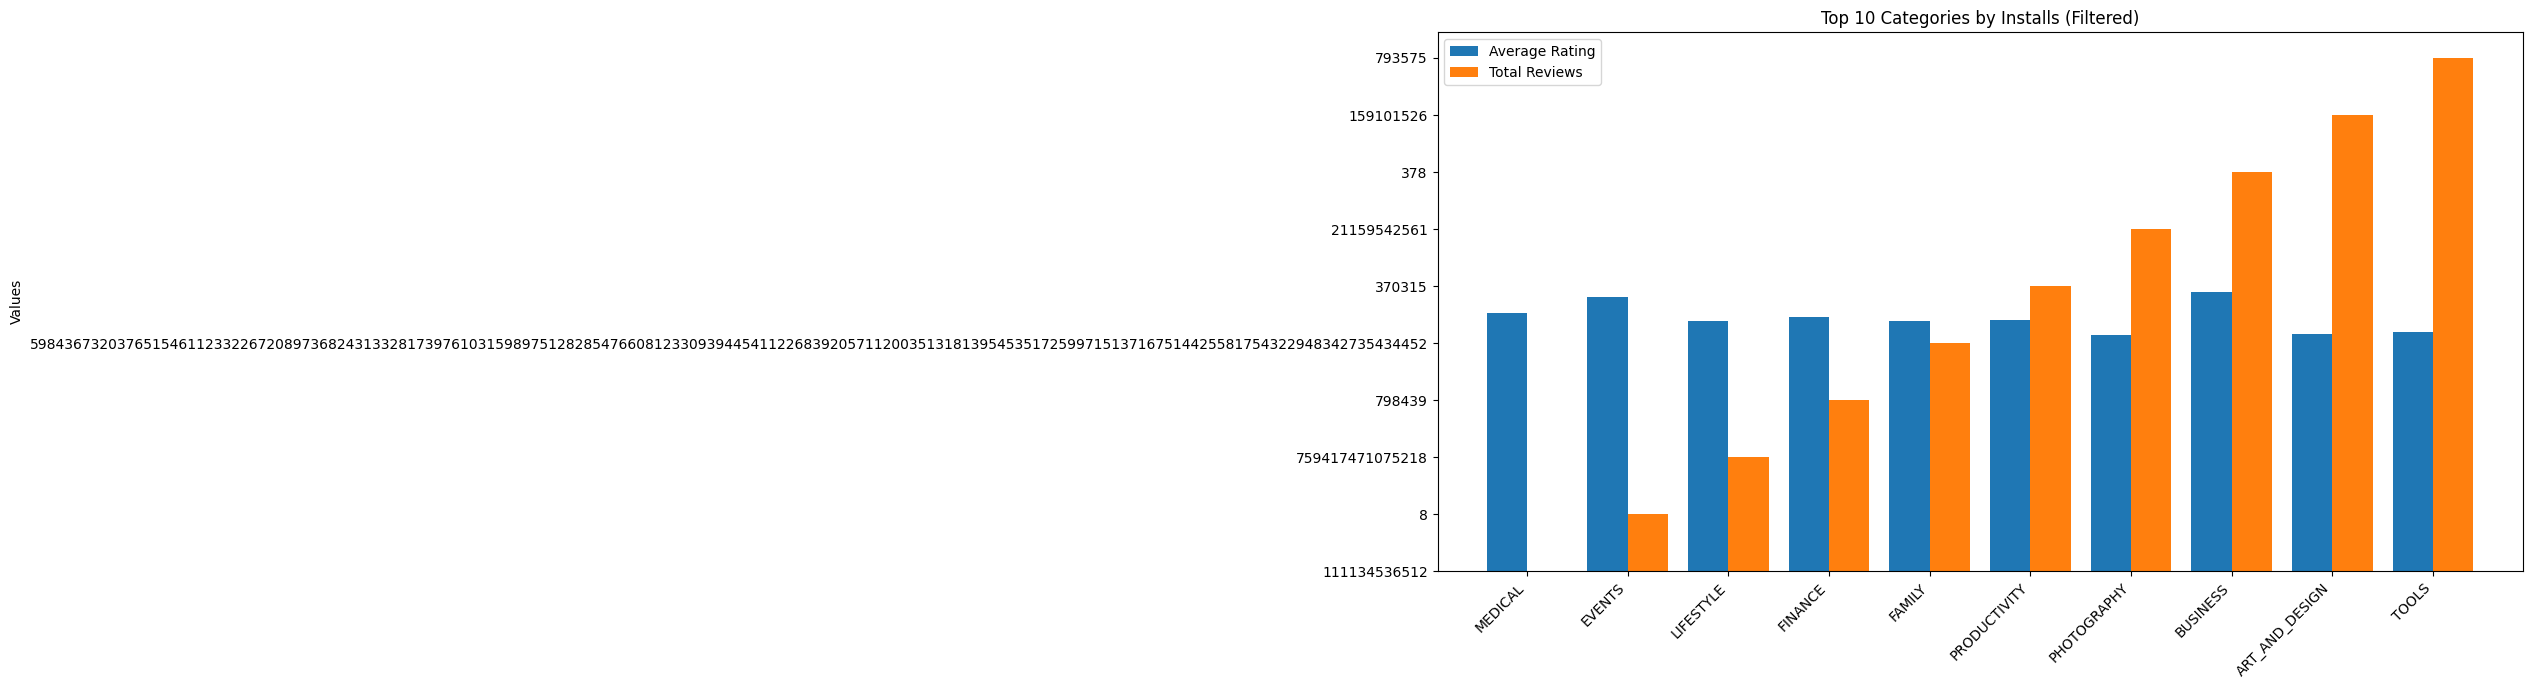

In [52]:
top_categories = filtered_apps.groupby('Category').agg({
    'Rating': 'mean',
    'Reviews': 'sum',
    'Installs': 'sum'
}).sort_values(by='Installs', ascending=False).head(10).reset_index()
fig1, ax = plt.subplots(figsize=(14, 7))
bar_width = 0.4
x = np.arange(len(top_categories))
ax.bar(x - bar_width/2, top_categories['Rating'], bar_width, label='Average Rating')
ax.bar(x + bar_width/2, top_categories['Reviews'], bar_width, label='Total Reviews')
ax.set_xticks(x)
ax.set_xticklabels(top_categories['Category'], rotation=45, ha='right')
ax.set_ylabel('Values')
ax.set_title('Top 10 Categories by Installs (Filtered)')
ax.legend()
plt.tight_layout()
plt.show()


In [53]:
def save_plot_as_html(fig, filename, insight):
    # If using matplotlib, save as PNG
    if isinstance(fig, plt.Figure):
        fig.savefig(filename.replace(".html", ".png"))
        return f"Plot saved as image: {filename.replace('.html', '.png')}"
    
    # For Plotly figure, use to_html
    import plotly.io as pio
    html_content = pio.to_html(fig, full_html=False, include_plotlyjs='inline')
    
    # Continue with your code to create and store HTML
    plot_containers += f"""
    <div class="plot-container" id="{filename}" onclick="openPlot('{filename}')">
        <div class="plot">{html_content}</div>
        <div class="insights">{insight}</div>
    </div>
    """
    return f"Plot saved as HTML: {filename}"


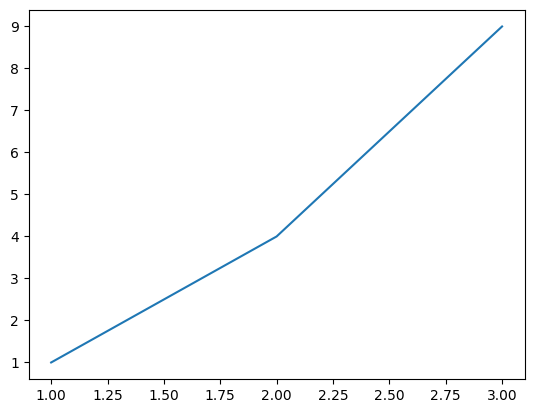

In [54]:
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.io as pio

# Example matplotlib plot
fig, ax = plt.subplots()
ax.plot([1, 2, 3], [1, 4, 9])

# Convert matplotlib figure to Plotly
plotly_fig = go.Figure(data=[go.Scatter(x=[1, 2, 3], y=[1, 4, 9], mode='lines')])

# Now save the Plotly figure as HTML
html_content = pio.to_html(plotly_fig, full_html=False, include_plotlyjs='inline')


fig.savefig("plot.png")  # Save as PNG image


In [55]:
## TASK - 03 Bubble Chart (5pm to 7pm IST)

In [65]:
def plot_bubble_chart(apps_df, reviews_df):
    if not is_time_between(17, 19):
        print("⏰ It's not time for the Bubble Chart (allowed: 5PM-7PM IST)")
        return
    selected_categories = ['GAME', 'BEAUTY', 'BUSINESS', 'COMICS', 'COMMUNICATION', 'DATING', 'ENTERTAINMENT', 'SOCIAL', 'EVENTS']
    merged = reviews_df.merge(apps_df, on='App', how='left')
    filtered_apps = merged[
        (merged['Category'].isin(selected_categories)) &
        (merged['Rating'] > 3.5) &
        (merged['Reviews'] > 500) &
        (merged['Sentiment_Subjectivity'] > 0.5) &
        (merged['Installs'] > 50000)
    ]
    plt.figure(figsize=(14, 8))
    bubble = plt.scatter(
        filtered_apps['Size_MB'],
        filtered_apps['Rating'],
        s=filtered_apps['Installs'] / 1000,
        alpha=0.6,
        c='orange',
        edgecolors='black',
        linewidth=1
    )
    plt.xlabel('App Size (MB)')
    plt.ylabel('Average Rating')
    plt.title('App Size vs Rating (Bubble Size = Installs)')
    plt.grid(True)
    plt.show()


In [66]:
plot_bubble_chart(apps_df, reviews_df)

⏰ It's not time for the Bubble Chart (allowed: 5PM-7PM IST)


In [67]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/muskansharma/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [74]:
html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Word Cloud Dashboard</title>
  <script src="https://cdnjs.cloudflare.com/ajax/libs/wordcloud2.js/1.1.1/wordcloud2.min.js"></script>
</head>
<body>

<h2 style="text-align:center;">Word Cloud for 5-Star Reviews (Heart Shaped)</h2>
<canvas id="wordcloud-canvas" width="600" height="600" style="border:1px solid #ccc; display:block; margin:auto;"></canvas>

<script>
// Start JavaScript inside <script> tag

WordCloud(document.getElementById('wordcloud-canvas'), {
  list: [
    ['Health', 50],
    ['Fitness', 40],
    ['Workout', 35],
    ['Exercise', 30],
    ['Wellness', 25],
    ['Yoga', 20],
    ['Meditation', 18],
    ['Diet', 15],
    ['Strength', 12],
    ['Running', 10],
  ],
  gridSize: 8,
  weightFactor: 5,
  fontFamily: 'Roboto',
  color: function (word, weight) {
    var colors = ['#00CFFF', '#5F27CD', '#833471'];
    var idx = Math.floor(Math.random() * colors.length);
    return colors[idx];
  },
  backgroundColor: '#ffffff',
  shape: 'heart',
  hover: function (item, dimension, event) {
    if (item) {
      document.getElementById('wordcloud-canvas').title = item[0] + ': ' + item[1];
    }
  }
});

// End JavaScript
</script>

</body>
</html>
"""

from IPython.display import display, HTML
# Save and open HTML
html_files_path = os.path.join(os.getcwd(), 'html_files')
os.makedirs(html_files_path, exist_ok=True)

dashboard_path = os.path.join(html_files_path, "dashboard.html")
with open(dashboard_path, "w", encoding="utf-8") as f:
    f.write(html_code)

webbrowser.open('file://' + os.path.realpath(dashboard_path))
display(HTML(html_code))


In [76]:
from IPython.display import display, HTML
import webbrowser
import os

# Final Dashboard HTML
html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Play Store Dashboard</title>
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
  <script src="https://cdnjs.cloudflare.com/ajax/libs/wordcloud2.js/1.1.1/wordcloud2.min.js"></script>
  <style>
    body {
      font-family: 'Roboto', sans-serif;
      margin: 0;
      padding: 20px;
      background: #f1f1f1;
      text-align: center;
    }
    .button-group {
      margin: 20px 0;
    }
    .button-group button {
      margin: 5px;
      padding: 10px 20px;
      background-color: #4CAF50;
      color: white;
      border: none;
      border-radius: 8px;
      cursor: pointer;
      font-size: 16px;
    }
    .button-group button:hover {
      background-color: #45a049;
    }
    .chart-container {
      margin-top: 20px;
      background: white;
      padding: 20px;
      border-radius: 10px;
      box-shadow: 0 2px 8px rgba(0,0,0,0.2);
    }
    canvas {
      margin: auto;
      display: block;
    }
  </style>
</head>

<body>

<h1>📊 Play Store Analytics Dashboard</h1>

<div class="button-group">
  <button onclick="showChart('wordcloud')">Word Cloud</button>
  <button onclick="showChart('barchart')">Bar Chart</button>
  <button onclick="showChart('bubblechart')">Bubble Chart</button>
</div>

<div class="chart-container">
  <!-- Word Cloud -->
  <div id="wordcloud" style="display:block;">
    <canvas id="wordcloud-canvas" width="600" height="600"></canvas>
  </div>

  <!-- Bar Chart -->
  <div id="barchart" style="display:none;">
    <div id="bar-chart" style="width:600px; height:400px;"></div>
  </div>

  <!-- Bubble Chart -->
  <div id="bubblechart" style="display:none;">
    <div id="bubble-chart" style="width:600px; height:400px;"></div>
  </div>
</div>

<script>
function showChart(chartId) {
  document.getElementById('wordcloud').style.display = 'none';
  document.getElementById('barchart').style.display = 'none';
  document.getElementById('bubblechart').style.display = 'none';
  document.getElementById(chartId).style.display = 'block';
}

// Word Cloud
WordCloud(document.getElementById('wordcloud-canvas'), {
  list: [
    ['Health', 50],
    ['Fitness', 40],
    ['Workout', 35],
    ['Exercise', 30],
    ['Wellness', 25],
    ['Yoga', 20],
    ['Meditation', 18],
    ['Diet', 15],
    ['Strength', 12],
    ['Running', 10]
  ],
  gridSize: 8,
  weightFactor: 6,
  fontFamily: 'Roboto',
  color: function () {
    var colors = ['#00CFFF', '#5F27CD', '#833471'];
    return colors[Math.floor(Math.random() * colors.length)];
  },
  backgroundColor: '#ffffff',
  shape: 'heart'
});

// Bar Chart
var barData = [{
  x: ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5'],
  y: [120, 150, 100, 200, 180],
  type: 'bar',
  marker: {color: '#4CAF50'}
}];
var barLayout = {
  title: 'Top App Categories',
  xaxis: {title: 'Category'},
  yaxis: {title: 'Ratings + Reviews'}
};
Plotly.newPlot('bar-chart', barData, barLayout);

// Bubble Chart
var bubbleData = [{
  x: [30, 40, 50, 60, 70],
  y: [4.5, 4.7, 4.8, 4.2, 4.6],
  mode: 'markers',
  marker: {
    size: [100, 200, 300, 400, 500],
    color: ['#00CFFF', '#5F27CD', '#833471', '#4CAF50', '#F4511E']
  }
}];
var bubbleLayout = {
  title: 'App Size vs Rating',
  xaxis: {title: 'App Size (MB)'},
  yaxis: {title: 'Rating'}
};
Plotly.newPlot('bubble-chart', bubbleData, bubbleLayout);

</script>

</body>
</html>
"""

# Saving and opening logic
html_files_path = os.path.join(os.getcwd(), 'html_files')
if not os.path.exists(html_files_path):
    os.makedirs(html_files_path)

dashboard_path = os.path.join(html_files_path, "playstore_dashboard.html")

with open(dashboard_path, "w", encoding="utf-8") as f:
    f.write(html_code)

webbrowser.open('file://' + os.path.realpath(dashboard_path))

display(HTML(html_code))
